Source:

huggingface: https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews

Tutorial:https://towardsdatascience.com/fine-tuning-hugging-face-model-with-custom-dataset-82b8092f5333

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/sharif/FineTuning/ipython(guide)')

In [3]:
!pip install transformers

     |████████████████████████████████| 1.8MB 5.9MB/s 
     |████████████████████████████████| 890kB 36.8MB/s 
     |████████████████████████████████| 2.9MB 35.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=deb34fa202d67af92fed25fd53bbf98b022e53794a00f15fec144b30abf04144
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
!pip3 install sentencepiece

     |████████████████████████████████| 1.2MB 5.3MB/s 


In [ ]:
!git clone https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews
GIT_LFS_SKIP_SMUDGE=1

fatal: destination path 'bert-fa-base-uncased-clf-persiannews' already exists and is not an empty directory.


In [5]:
!pip install -q clean-text[gpl]

     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 71kB 3.7MB/s 
     |████████████████████████████████| 245kB 7.5MB/s 


In [6]:
!pip install -q hazm

     |████████████████████████████████| 317kB 4.0MB/s 
     |████████████████████████████████| 1.4MB 24.7MB/s 
     |████████████████████████████████| 235kB 32.8MB/s 


In [7]:
import torch
import numpy
import pandas
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoConfig,TFAutoModel,AutoModel
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample
from sklearn.metrics import classification_report, accuracy_score

import hazm
from cleantext import clean


In [8]:
# specify GPU
device = torch.device("cuda")

## Data

In [9]:
data = pandas.read_csv('/content/drive/MyDrive/sharif/Spider/Data/unpreprocessed_dataset.csv')

# counter
count_data = data.copy()
count_data = count_data.dropna().reset_index(drop=True)
count = {}
tags_list = pandas.read_excel('../Tags.xlsx',header = None)
tags_list.columns = ['tag']
for _,tag in tags_list.iterrows():
  if tag['tag']!='ویرگول' and tag['tag']!=None and tag['tag']!='':
    count[re.sub(' ','',tag['tag'].lower())] = 0

for indx,d in count_data.iterrows():
  tags = re.sub('\'|\[|\]','',d['tag']).split(',')
  
  for tag in tags:
    if tag.strip().lower() in tags_list.values:
      count[tag.strip().lower().replace(' ','')]+=1 
# count

(array([30., 20., 14.,  7.,  0.,  0.,  2.,  1.,  2.,  2.]),
 array([  34. ,  404.1,  774.2, 1144.3, 1514.4, 1884.5, 2254.6, 2624.7,
        2994.8, 3364.9, 3735. ]),
 <a list of 10 Patch objects>)

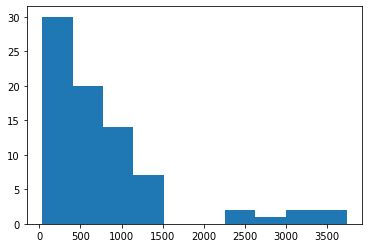

In [ ]:
import  matplotlib.pyplot as plt
plt.hist([count[k] for k in list(count.keys())])

In [10]:
limit_number = 1500

In [11]:
for i in range(len(data)):

    text=data.loc[i,"body"]
    tags = data.loc[i,'tag']
    data.loc[i,'tag'] = re.sub('ویرگول|c\+\+','',tags.lower())
    tags = re.sub('\[|\]|\'|=|ویرگول',' ',tags)
    tags_list = [t.strip() for t  in tags.split(',') if (t!=' ' and t!='' and (re.sub('[ ]*','',t) in list(count.keys())))]

    # balancing
    if len(tags_list) <1:
      data.loc[i,"body"]=None
      continue
    min_count = min([count[tag.replace(' ','')] for tag in tags_list if (tag.replace(' ','') in list(count.keys()))])

    if min_count<limit_number :

      replications = (limit_number - min_count)//min_count

      d_temp = data.iloc[i,:].copy()
      for _ in range(replications):

        data = data.append(d_temp)
        for tag in tags_list:
          count[tag.replace(' ','')] += 1
    
    for tag in tags_list:
        if count[tag.replace(' ','')]>limit_number:
          for t in tags_list:
            count[t.replace(' ','')] -=1
          data.loc[i,"body"]=None

    if i%500==0:
      print("Record: up to "+str(i)+" from " ,str(len(data)),"is processed.")

Record: up to 0 from  35671 is processed.
Record: up to 500 from  37092 is processed.
Record: up to 1000 from  38099 is processed.
Record: up to 1500 from  38690 is processed.
Record: up to 2000 from  39116 is processed.
Record: up to 2500 from  39514 is processed.
Record: up to 3000 from  39867 is processed.
Record: up to 3500 from  40172 is processed.
Record: up to 4000 from  40519 is processed.
Record: up to 4500 from  40730 is processed.
Record: up to 5000 from  40926 is processed.
Record: up to 5500 from  41121 is processed.
Record: up to 6000 from  41268 is processed.
Record: up to 6500 from  41445 is processed.
Record: up to 7000 from  41578 is processed.
Record: up to 7500 from  41733 is processed.
Record: up to 8000 from  41884 is processed.
Record: up to 8500 from  42062 is processed.
Record: up to 9000 from  42217 is processed.
Record: up to 9500 from  42356 is processed.
Record: up to 10000 from  42502 is processed.
Record: up to 10500 from  42633 is processed.
Record: up t

In [12]:
data = data.dropna().reset_index(drop=True)
data.head()

,body,tag
0,اگر جزو آن دسته دولوپرهایی هستید که پس از چندی...,'' مهارت''
1,دولوپرها همواره به ابزارهای مختلفی نیاز دارند ...,'' کاتلین''
2,چنانچه افرادی را می‌شناسید که جزو توسعه‌دهندگا...,'' برنامه نویسی اندروید''
3,Microsoft Research Open Data یک ریپازیتوری مبت...,'' داده کاوی''
4,امروزه کامپیوترها بخش مهم و بزرگی از زندگی ما ...,'' کامپیوتر''


In [13]:
data.shape

(34536, 2)

In [14]:
# counter 
count_data = data.copy()
count_data = count_data.dropna().reset_index(drop=True)
count = {}
tags_list = pandas.read_excel('../Tags.xlsx',header = None)
tags_list.columns = ['tag']
for _,tag in tags_list.iterrows():
  if tag['tag']!='ویرگول' and tag['tag']!=None and tag['tag']!='':
    count[re.sub(' ','',tag['tag'].lower())] = 0

for indx,d in count_data.iterrows():
  tags = re.sub('\'|\[|\]','',d['tag']).split(',')
  
  for tag in tags:
    if tag.strip().lower() in tags_list.values:
      count[tag.strip().lower().replace(' ','')]+=1 

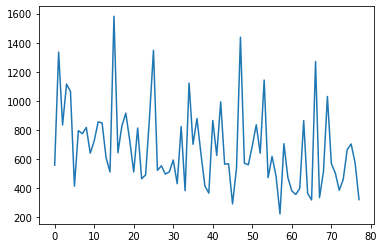

In [ ]:
import matplotlib.pyplot as plt
plt.plot([count[i] for i in list(count.keys())])

In [15]:
# #All data befor pre-processing...
# print(data['body'])
# print(data.shape)
X = data["body"].values.tolist()
# y = pandas.read_csv('../Data/limited_to_'+str(limit_number)+'.csv')
y=data["tag"].values.tolist()
labels = []
tag=[]
for item in y:
  labels += [i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' ']
  tag.append([i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' '])
labels = list(set(labels))
mlb = MultiLabelBinarizer()
Y=mlb.fit_transform(tag)

In [ ]:
# for i in range(10):
#   print(X[i])
#   print(Y[i])

In [16]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [17]:
# cleaning taxt
clean_x=[]
for t in X:
  clean_x.append(cleaning(t))


In [ ]:
for i in range(10):
  print(clean_x[i])

اگر جزو آن دسته دولوپرهایی هستید که پس از چندین و چند سال کدنویسی و کسب تجربه کماکان از عملکرد خود راضی نیستید، توصیه می‌‌کنیم به ارزیابی دقیق‌تر کار خود بپردازید. به عبارت دیگر، ببینید که آیا حرفه‌‌ای عمل می‌‌کنید؟ آیا از نسبت میان میزان proficiency و competency خود اطلاع دارید؟ آیا می‌‌دانید چه راه‌کارهایی را برای افزایش بهره‌‌وری خود می‌بایست در پیش بگیرید؟ واقعیت امر آن است که در اغلب موارد، دو مفهوم proficiency و competency مشابه یکدیگر در نظر گرفته می‌شوند؛ اما در حقیقت این‌طور نیست! چنانچه این دو واژه واقعا هم‌معنا بودند، هر کسی که در هر کاری سررشته داشت می‌بایست در کار خود بهترین می‌بود؛ به‌ علاوه اینکه شکی نیست که در قرن بیست و یکم، هر روز بیش از روز قبل نیاز به کسب تخصص احساس می‌شود. با‌توجه به میزان و شتاب گسترش اطلاعات از یک سو و همچنین رقابت شدید متخصصان برای ربودن گوی سبقت از رقبای خود از سوی دیگر، قطعا کسب proficiency برای فعالان حوزهٔ کسب‌وکار یک ضرورت است. به‌ طور کلی، آنچه در ادامه قصد داریم مورد بررسی قرار دهیم این است که به چه شکل می‌توان با تلفیق proficiency و comp

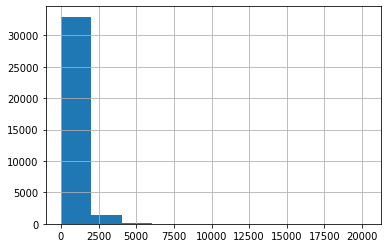

In [ ]:
seq_len = [len(i.split()) for i in clean_x]
pandas.Series(seq_len).hist(bins = 10)

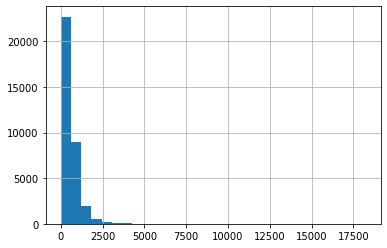

In [ ]:
seq_len = [len([j for j in i.split() if len(j)>2]) for i in X]
pandas.Series(seq_len).hist(bins = 30)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(clean_x,Y , test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print('train: ', len(X_train) , '\ntest: ', len(X_test) , '\nval: ', len(X_val) ,"\ny_tain:",len(y_train) )

train:  20721 
test:  6908 
val:  6907 
y_tain: 20721


In [19]:
##we would load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")

In [ ]:
#example
text = "ما در هوشواره معتقدیم با انتقال صحیح دانش و آگاهی، همه افراد میتوانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است."
tokenized=tokenizer.tokenize(X_train[0])
input_ids = tokenizer.convert_tokens_to_ids(tokenized)
print(tokenized)
print(input_ids)


['سلام', 'من', 'مهیار', 'صالحی', 'و', 'یا', 'همون', 'mah', '##ya', 'ap', 'هستم', '##خیلی', 'از', 'کاررا', '##ن', 'ویندوز', 'با', 'این', 'موضوع', 'مواجه', 'شدند', 'که', 'بخوان', 'وقتی', 'روی', 'یک', 'لینک', 'کلیک', 'میکنند', 'و', 'یا', 'قصد', 'باز', 'کردن', 'یک', 'عکس', 'یا', 'فیلم', 'را', 'داشته', 'باشند', 'به', 'برنامههای', 'مخصوص', 'ویندوز', 'مثل', 'مرورگر', 'اج', 'که', 'نسخه', 'جدیدی', 'از', 'اینترنت', 'اکسپلورر', 'هست', 'منتقل', 'بشن', '##اما', 'مرورگر', 'مورد', 'علاقه', 'خیلیها', 'گوگل', 'یا', 'فایر', 'فاکس', 'میباشد', '##پس', 'راه', 'منطقی', 'برای', 'کوچ', 'از', 'اج', 'به', 'کروم', 'یا', 'فایر', 'فاکس', 'چیست', '؟', '؟', 'کپی', 'کردن', 'لینک', 'و', 'الحاق', '(', 'past', '##e', ')', 'کردن', 'ان', 'در', 'کروم', '؟', '؟', '؟', 'به', 'نظرم', 'منطقی', 'نیست', '!', 'راهی', 'که', 'ویندوز', '۱۰', 'برای', 'شما', 'قرار', 'داده', 'اینه', 'که', 'کروم', 'یا', 'فایر', 'فاکس', 'رو', 'به', 'عنوان', 'مسیر', 'پیش', 'فرض', 'انتخاب', 'کنید', '!', '!', 'حالا', 'از', 'طریق', 'مسیر', 'زیر', 'وارد', 'بخ

In [ ]:
# encode text
sent_id = tokenizer.batch_encode_plus(X_train[:10], padding=True, return_token_type_ids=False)

In [ ]:
sent_id

{'input_ids': [[2, 4285, 2842, 50414, 11451, 1379, 2880, 17802, 27717, 20250, 9731, 6794, 11366, 2791, 68824, 2011, 7358, 2799, 2802, 3444, 4574, 3589, 2800, 5168, 3711, 3040, 2829, 11827, 7843, 3133, 1379, 2880, 4790, 3012, 3274, 2829, 4655, 2880, 3169, 2803, 3151, 3689, 2789, 4514, 5256, 7358, 3826, 11999, 2977, 2800, 4207, 5019, 2791, 4900, 34437, 2952, 5373, 12914, 6816, 11999, 3050, 5351, 10378, 5934, 2880, 26220, 14125, 3388, 6496, 3148, 7181, 2831, 3602, 2791, 2977, 2789, 9399, 2880, 26220, 14125, 5825, 1350, 1350, 9546, 3274, 11827, 1379, 14053, 1006, 69324, 2033, 1007, 3274, 2808, 2786, 9399, 1350, 1350, 1350, 2789, 12269, 7181, 3152, 1001, 5757, 2800, 7358, 3396, 2831, 3124, 2959, 3171, 9225, 2800, 9399, 2880, 26220, 14125, 2840, 2789, 3014, 3910, 2958, 5875, 3229, 3116, 1001, 1001, 4888, 2791, 3626, 3910, 3150, 3332, 3108, 11384, 5276, 2905, 3040, 5939, 28024, 2880, 17802, 7358, 2786, 15274, 6923, 7796, 1379, 2801, 3040, 38329, 11384, 2800, 3102, 40402, 3060, 7843, 3116, 279

In [20]:
sentence_maxlen=128

In [21]:
##Tokenize training and validation sentences:
train_encodings = tokenizer.batch_encode_plus(X_train,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

val_encodings = tokenizer.batch_encode_plus(X_val,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

test_encodings=tokenizer.batch_encode_plus(X_test,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

In [ ]:
train_encodings[0]

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [22]:
import torch
import torch.nn as nn

# for train set
train_seq = torch.tensor(train_encodings['input_ids'])
train_mask = torch.tensor(train_encodings['attention_mask'])
train_y = torch.FloatTensor(y_train)

# for validation set
val_seq = torch.tensor(val_encodings['input_ids'])
val_mask = torch.tensor(val_encodings['attention_mask'])
val_y = torch.FloatTensor(y_val)

# for test set
test_seq = torch.tensor(test_encodings['input_ids'])
test_mask = torch.tensor(test_encodings['attention_mask'])
test_y = torch.FloatTensor(y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

In [ ]:
train_y[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])

In [23]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [24]:
# example


text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
print(sent_id)

seq = torch.tensor(sent_id['input_ids'])
mask = torch.tensor(sent_id['attention_mask'])
train_y = torch.tensor([0,1])

transformer_model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")
cls_hs=transformer_model(seq,mask)
print(cls_hs)
print(cls_hs[0])
print(cls_hs[1])
print(cls_hs[1].shape)
print(cls_hs[0].shape)

{'input_ids': [[2, 32071, 9574, 1026, 89390, 36260, 84378, 40908, 2041, 4, 0], [2, 13632, 25909, 70608, 1011, 40716, 2033, 1026, 89390, 36260, 4]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}



BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0526,  0.5571, -0.4614,  ..., -0.0968,  0.4727,  0.1742],
         [-0.2566,  1.5509, -2.0229,  ..., -1.1688, -0.4160,  0.1496],
         [-0.1851,  0.1336, -1.3189,  ..., -0.5912, -0.4864,  0.4295],
         ...,
         [-0.2249,  0.1459, -1.4157,  ..., -0.1764,  0.6163, -0.5646],
         [-0.3767, -0.2304, -0.3158,  ..., -0.5575,  0.0901,  0.6220],
         [-0.2883,  0.2287, -1.5781,  ..., -0.3559,  0.3813,  0.0665]],

        [[ 0.0939, -0.5881, -1.2552,  ...,  0.9090,  0.5908, -0.1969],
         [-0.2802, -0.9775, -1.5731,  ...,  0.0902,  0.5980, -0.6988],
         [-0.2920, -0.6260, -0.9620,  ..., -0.4935,  0.6855, -1.1112],
         ...,
         [-0.1571, -0.1198, -2.0160,  ...,  0.3612,  0.7098, -0.9345],
         [-0.0399, -0.9591, -1.5613,  ...,  0.6662,  0.1020, -0.0502],
         [-0.4564, -1.5508, -0.4116,  ..., -0.1108,  1.1311,  0.2711]]],
       grad_fn=<NativeLayerNormBackward>), pooler_ou

## Model

In [25]:
transformer_model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")

In [26]:
# freeze all the parameters
for param in transformer_model.parameters():
    param.requires_grad = False
    

In [27]:
classnum=len(labels)
classnum

78

In [28]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 

      self.dropout_1 = nn.Dropout(0.1)

      self.fc1 = nn.Linear(768,512)
      self.bn_1 = nn.BatchNorm1d(512)
      self.elu_1 =  nn.ELU()

      self.fc2 = nn.Linear(512,256)
      self.bn_2 = nn.BatchNorm1d(256)
      self.elu_2 =  nn.ELU()
      
      self.dropout_2 = nn.Dropout(0.1)

      self.fc3 = nn.Linear(256,classnum)
      self.bn_3 = nn.BatchNorm1d(classnum)

      self.sigmoid = nn.Sigmoid()

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.dropout_1(cls_hs[1])

      x = self.fc1(x)
      x = self.bn_1(x)
      x = self.elu_1(x)

      x = self.fc2(x)
      x = self.bn_2(x)
      x = self.elu_2(x)
      
      x = self.dropout_2(x)

      x = self.fc3(x)
      x = self.bn_3(x)

      x = self.sigmoid(x)

      return x

In [29]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(transformer_model)

# push the model to GPU
model = model.to(device)

In [30]:
# optimizer from hugging face transformers
from transformers import AdamW


# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)

In [31]:
##Calculating weights 
class_counts=[0]*classnum
for cl in Y:
    #  print(cl)
     for i in range(classnum):
      #  print(i)
       if cl[i]==1:
          class_counts[i]+=1
print(class_counts)

weight=[]
for indx in range(classnum):
  weight.append(((class_counts[indx]/len(Y))))

print(weight)

# class_weight= torch.tensor(weight,dtype=torch.float)
class_weight = torch.FloatTensor(weight)
class_weight = class_weight.to(device)
print(class_weight)

[563, 574, 865, 356, 385, 382, 858, 459, 511, 482, 774, 222, 291, 380, 320, 855, 638, 1582, 698, 415, 724, 831, 505, 703, 365, 1030, 557, 827, 848, 835, 472, 704, 522, 661, 643, 810, 1115, 334, 536, 496, 1143, 640, 413, 823, 1122, 363, 315, 993, 890, 593, 430, 464, 568, 640, 795, 567, 503, 511, 1438, 724, 1065, 558, 848, 691, 618, 1335, 490, 610, 1270, 877, 553, 1348, 624, 511, 465, 915, 571, 817]
[0.01630182997451934, 0.016620338197822562, 0.025046328468844106, 0.010308084317813297, 0.011147787815612695, 0.011060921936529997, 0.024843641417651146, 0.013290479499652537, 0.01479615473708594, 0.013956451239286542, 0.022411396803335648, 0.0064280750521195276, 0.008425990271021543, 0.011003011350474866, 0.009265693768820941, 0.024756775538568452, 0.01847347695158675, 0.04580727356960852, 0.020210794533240678, 0.012016446606439657, 0.020963632151957377, 0.02406184850590688, 0.014622422978920547, 0.020355570998378505, 0.010568681955061386, 0.029823951818392404, 0.01612809821635395, 0.0239460

In [32]:
# loss_func =nn.MultiLabelMarginLoss()
# loss_func=nn.BCEWithLogitsLoss(weight=class_weight)
loss_func=nn.BCELoss(weight=class_weight)
# loss_func=nn.NLLLoss(weight=class_weight)

In [33]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
   
    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    
    # compute the loss between actual and predicted values
    loss=loss_func(preds,labels)
    
    # loss=0
      
    # for b in range(batch_size):
    #   for l in range(classnum):
    #     print(preds[b][l], labels[b][l])
    #     loss += loss_func(preds[b][l], labels[b][l])

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [34]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)
      
      # compute the validation loss between actual and predicted values

      # loss=0
      # for b in range(batch_size):
      #   for l in range(classnum):
      #     loss += loss_func(preds[b][l], labels[b][l])
      
      loss=loss_func(preds,labels)
      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [35]:
# number of training epochs
epochs = 50

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_3fc.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50
  Batch    50  of    648.
  Batch   100  of    648.
  Batch   150  of    648.
  Batch   200  of    648.
  Batch   250  of    648.
  Batch   300  of    648.
  Batch   350  of    648.
  Batch   400  of    648.
  Batch   450  of    648.
  Batch   500  of    648.
  Batch   550  of    648.
  Batch   600  of    648.

Evaluating...
  Batch    50  of    216.
  Batch   100  of    216.
  Batch   150  of    216.
  Batch   200  of    216.

Training Loss: 0.012
Validation Loss: 0.010

 Epoch 2 / 50
  Batch    50  of    648.
  Batch   100  of    648.
  Batch   150  of    648.
  Batch   200  of    648.
  Batch   250  of    648.
  Batch   300  of    648.
  Batch   350  of    648.
  Batch   400  of    648.
  Batch   450  of    648.
  Batch   500  of    648.
  Batch   550  of    648.
  Batch   600  of    648.

Evaluating...
  Batch    50  of    216.
  Batch   100  of    216.
  Batch   150  of    216.
  Batch   200  of    216.

Training Loss: 0.008
Validation Loss: 0.006

 Epoch 3 / 50
  B

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

Loading saved model:

In [ ]:
# # torch.cuda.empty_cache()
# # pass the pre-trained BERT to our define architecture
# model = BERT_Arch(transformer_model)

# # push the model to GPU
# model = model.to(device)

In [ ]:
# #load weights of best model
# path = 'saved_weights_3fc.pt'
# model.load_state_dict(torch.load(path))

After loading model:

In [ ]:
y_pred=[]
y_true=[]
for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      # outputs_before_sigmoid = model(sent_id, mask)
      preds = model(sent_id, mask)
      # print(preds)
      # print(preds.cpu().numpy())
      
      
      # outputs_before_sigmoid = outputs_before_sigmoid.cpu().numpy()
      # model's performance
    # preds = numpy.argmax(preds, axis = 1)
    # print(len(preds),len(preds[0]))
    # measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    # print(measure)


    # preds=[]
    # for l in range(len(outputs_before_sigmoid)):
    #   preds.append(torch.sigmoid(outputs_before_sigmoid[l]))
    # preds = preds.cpu().numpy()
    # print(preds)
    # measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    # for l in range(len(outputs_before_sigmoid)):
    #   temp=[]
    #   for value in preds:
    #     if value >= measure:
    #       temp.append(1)
          
    #     else:
    #       temp.append(0)
    #   y_pred.append(temp)
    #   y_true.append(labels.cpu().numpy()[l])
    #   # print( preds[l])
    #   print("temp:",(temp))
    #   print("labels:",labels.cpu().numpy()[l])
    
    # print(labels.cpu().numpy()[0], preds[0])
  

    # for l in range(len(preds)):
    #   preds.append(torch.sigmoid(outputs_before_sigmoid[l]))
    # preds = preds.cpu().numpy()
    # print(preds)
    preds = preds.cpu().numpy()
    measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    for l in range(len(preds)):
      temp=[]
      for value in preds[l]:
        if value >= measure:
          temp.append(1)
          
        else:
          temp.append(0)
      y_pred.append(temp)
      y_true.append(labels.cpu().numpy()[l])
      # print( preds[l])
      # print("temp:",(temp))
      # print("labels:",labels.cpu().numpy()[l])

print(classification_report(y_true, y_pred))